conf
[[1479  668]
 [ 764 1383]]
f1
[0.6738041  0.65888518]
roc
(array([0.        , 0.31113181, 1.        ]), array([0.        , 0.64415463, 1.        ]), array([inf,  1.,  0.]))


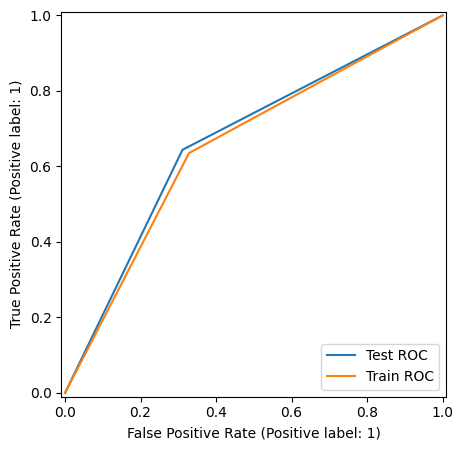

In [270]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
data_url = 'loan_applic.csv'  # Replace this with your dataset URL or local path
df = pd.read_csv(data_url)
df = df.drop(columns=['Application Number','crime_record','Application: BPA Broker Negotiation'])
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)
from datetime import datetime
df['Application: Close Date'] = df['Application: Close Date'].apply(lambda x: datetime.strptime(x, "%m/%d/%Y").timestamp())
df['Yearly Total Sales'] = pd.to_numeric(df['Yearly Total Sales'].str.replace(',', '')) # a lot
numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()
object_cols = df.select_dtypes(include='object').columns.tolist()

for col in object_cols:
    df[col] = df[col].fillna('Missing')
    
for col in numeric_columns:
    mean_value = df[col].mean()
    df[col] = df[col].fillna(mean_value)

y = df['Outcome']
X = df.drop(columns=['Outcome'])


tmp = X[numeric_columns]
pearson_corr = tmp.corr(method='pearson')
spearman_corr = tmp.corr(method='spearman')
threshold = 0.8  # You can adjust this threshold as needed
high_corr_pairs = []
for i in range(len(pearson_corr.columns)):
    for j in range(i):
        if abs(pearson_corr.iloc[i, j]) > threshold:
            high_corr_pairs.append((pearson_corr.columns[i], pearson_corr.columns[j], pearson_corr.iloc[i, j]))
for i in range(len(spearman_corr.columns)):
    for j in range(i):
        if abs(spearman_corr.iloc[i, j]) > threshold:
            high_corr_pairs.append((spearman_corr.columns[i], spearman_corr.columns[j], spearman_corr.iloc[i, j]))
features_to_remove = set()
for pair in high_corr_pairs:
    features_to_remove.add(pair[0])  # Add first feature from pair
    features_to_remove.add(pair[1])  # Add second feature from pair
X = X.drop(columns=features_to_remove)

lol_x = X.copy(deep=True)


object_cols = X.select_dtypes(include='object').columns.tolist()
label_encoder = {}
for col in object_cols:
    label_encoder[col] = LabelEncoder()
    X[col] = label_encoder[col].fit_transform(X[col].astype(str))
label_encoder['y'] = LabelEncoder()
y = label_encoder['y'].fit_transform(y.astype(str))


from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
X, y = smote.fit_resample(X, y)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1,test_size=0.3,random_state=0)
for train_index, test_index in sss.split(X,y):
    X_train, X_test = X[train_index],X[test_index]
    y_train, y_test = y[train_index],y[test_index]

from sklearn.linear_model import LogisticRegression
stack_clf = LogisticRegression()
stack_clf.fit(X_train, y_train)
predictions = stack_clf.predict(X_test)
predictions_train = stack_clf.predict(X_train)
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(5,5))
RocCurveDisplay.from_predictions(y_test,predictions, ax=ax, label='Test ROC')
RocCurveDisplay.from_predictions(y_train,predictions_train, ax=ax, label='Train ROC')
import sklearn
print('conf')
print(sklearn.metrics.confusion_matrix(y_test,predictions))
print('f1')
print(sklearn.metrics.f1_score(y_test,predictions,average=None))
print('roc')
print(sklearn.metrics.roc_curve(y_test,predictions))

In [274]:
me

,Application: Origination Fee,Application: Remittance Frequency,Primary Contact Gender,Application: Close Date,customer Age,Average Daily Negatives,Avg Daily Bank Balance,Avg Number of Monthly Deposits,Credit Score,Daily Bank Balance v/s Daily Payment,Has Website,Industry,Inquiry Count,Office Space,Open Bankruptcy,Position,Public Records,Sales to Payment,Shipping State,Sum of Monthly Personal Debt,Time In Business Actual,Type
0,2.0,Daily,Missing,1.483394e+09,35.0,0.0,2824.15,3.33,741.0,0,Yes,Healthcare,24.0,Rent,0.0,First,0.0,18.0,NJ,4792.0,24.0,New Deal


In [328]:
lol_x

,Application: Origination Fee,Application: Remittance Frequency,Primary Contact Gender,Application: Close Date,customer Age,Average Daily Negatives,Avg Daily Bank Balance,Avg Number of Monthly Deposits,Credit Score,Daily Bank Balance v/s Daily Payment,Has Website,Industry,Inquiry Count,Office Space,Open Bankruptcy,Position,Public Records,Sales to Payment,Shipping State,Sum of Monthly Personal Debt,Time In Business Actual,Type
0,2.0,Daily,Missing,1.483394e+09,35.0,0.00,2824.15,3.33,741.0,30.9225,Yes,Healthcare,24.0,Rent,0.0,First,0.0,18.00,NJ,4792.0,24.0,New Deal
1,2.0,Daily,Male,1.483394e+09,47.0,0.25,2401.76,36.50,624.0,24.7196,Yes,Dentists,18.0,Rent,0.0,Second,0.0,18.00,OH,2867.0,17.7,New Deal
2,2.0,Daily,Male,1.483394e+09,58.0,0.67,606.48,46.67,590.0,10.1844,No,Retail,51.0,Rent,0.0,Second,0.0,6.50,NY,1331.0,17.5,New Deal
3,2.0,Daily,Male,1.483394e+09,62.0,0.67,1737.83,53.33,650.0,11.3280,Yes,Spa/Salon,1.0,Own,0.0,First,3.0,0.00,MN,16491.0,5.1,New Deal
4,2.0,Daily,Female,1.483394e+09,64.0,0.67,2194.66,7.00,504.0,15.1043,Yes,Contracting,13.0,Rent,0.0,First,0.0,0.00,PA,1373.0,1.5,New Deal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9790,3.0,Daily,Male,1.546207e+09,51.0,0.82,81764.80,6.55,741.0,55.0047,Yes,Law Offices,4.0,Rent,0.0,First,0.0,0.00,TX,2400.0,19.8,Paid Renewal
9791,3.0,Daily,Male,1.546207e+09,54.0,4.00,121173.15,22.00,728.0,91.1508,Yes,Wholesale,12.0,Own,0.0,First,0.0,0.00,LA,7184.0,28.0,Potential Dupe
9792,3.0,Daily,Male,1.546207e+09,46.0,0.33,6487.52,51.33,726.0,18.1586,Yes,Wholesale,0.0,Rent,0.0,First,0.0,0.00,PA,1865.0,5.6,Paid Renewal
9793,3.0,Daily,Male,1.546207e+09,54.0,1.00,10906.83,20.00,642.0,8.9881,Yes,Contracting,18.0,Rent,1.0,First,1.0,0.00,CA,5138.0,18.6,New Deal


In [332]:
me = lol_x.head(n=1).copy(deep=True)
me['customer Age'] = 1111
for col in object_cols:
    me[col] = label_encoder[col].transform(me[col].astype(str))
me = scaler.transform(me)
stack_clf.predict(me)

array([1])

In [279]:
label_encoder['y'].transform(['Pos'])

array([1])

In [306]:
stack_clf.coef_[0]

array([ 0.00445066, -0.05223103,  0.05034719, -0.34418542,  0.10989034,
       -0.04449734, -0.05616342, -0.00254814,  0.11023963,  0.1352557 ,
        0.37433777, -0.00824017, -0.20272453,  0.12621045, -0.01907446,
        0.22159221,  0.02234959, -0.18098337,  0.05627913, -0.03041505,
        0.14810703,  0.33025172])

In [321]:
lol_x.columns

Index(['Application: Origination Fee', 'Application: Remittance Frequency',
       'Primary Contact Gender', 'Application: Close Date', 'customer Age',
       'Average Daily Negatives', 'Avg Daily Bank Balance',
       'Avg Number of Monthly Deposits', 'Credit Score',
       'Daily Bank Balance v/s Daily Payment', 'Has Website', 'Industry',
       'Inquiry Count', 'Office Space', 'Open Bankruptcy', 'Position',
       'Public Records', 'Sales to Payment', 'Shipping State',
       'Sum of Monthly Personal Debt', 'Time In Business Actual', 'Type'],
      dtype='object')

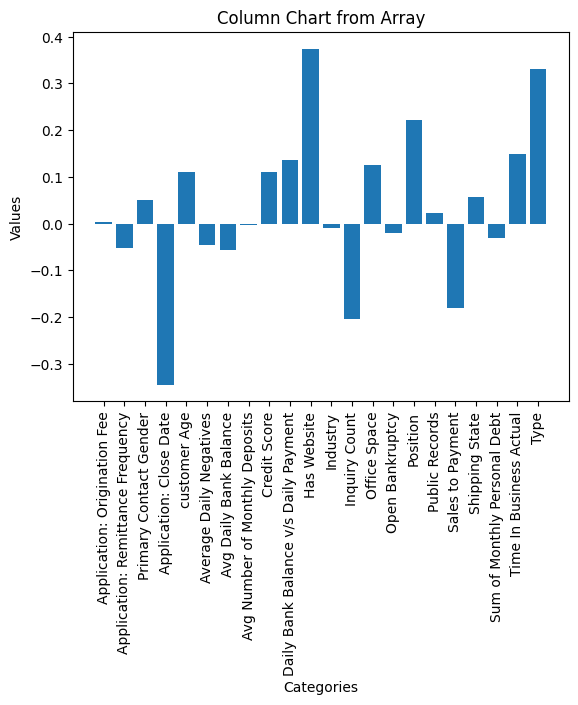

In [323]:
import numpy as np
import matplotlib.pyplot as plt

# Sample data (array)
categories = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22]
values = np.array([1.00445066, -11.05223103, 1, 2])

# Create a bar chart
plt.bar(lol_x.columns, stack_clf.coef_[0])

# Add labels and title
plt.xlabel('Categories')
plt.ylabel('Values')
plt.title('Column Chart from Array')
plt.xticks(rotation='vertical')

# Display the plot
plt.show()